In [150]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Feb 20 15:10:00 2018

@author: Yacalis
"""

import os
import json
import numpy as np
from Callbacks import Callbacks
from Config import Config
from dataLoader import retrieve_data, retrieve_celeba_data
from folder_defs import get_log_dir, get_data_dir, get_train_dir, get_test_dir, get_celeba_dir
from build_model import build_model
from save_model import save_model
from get_data_dict import get_data_dict, get_new_data_dict, get_celeba_data
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from Optimizer import Optimizer
from random import shuffle
import matplotlib.pyplot as plt

In [4]:
print('Beginning program')

Beginning program


In [5]:
# get config
config = Config().config
print('change lr:', config.change_lr)
print('change bs:', config.change_bs)
print('max epochs:', config.epochs)
print('model:', config.complexity)
if config.change_bs and config.change_lr:
    print('[!] Whoops: both config.change_bs and config.change_lr are '
          'true -- at least one of them should be false.')

unparsed config options: ['-f', '/Users/Yacalis/Library/Jupyter/runtime/kernel-5af503f7-c26c-4ed2-a43b-4968ba8d7e46.json']
change lr: True
change bs: False
max epochs: 20
model: celeba


In [6]:
# get directories
log_dir = get_log_dir(config)
data_dir = get_data_dir()
image_dir = get_celeba_dir()
print('log dir:', log_dir)
print('data dir:', data_dir)
print('image_dir:', image_dir)

log dir: /Users/Yacalis/Projects/Tensorflow/cs274c-data/logs/0313_1234-clr-v_celeba
data dir: /Users/Yacalis/Projects/Tensorflow/cs274c-data/celeba
image_dir: /Users/Yacalis/Projects/Tensorflow/cs274c-data/celeba/img_align_celeba_178x218


In [ ]:
# get data
print('Loading data...')
data_dict = get_celeba_data(data_dir)

In [151]:
# instantiate arrays
x_data = []
y_data = []
keys = data_dict.keys()
i = 1
images = os.listdir(image_dir)
shuffle(images)

In [152]:
try:
    for file in images:
        if i > 1000:
            break
        if file in keys:
            filepath = os.path.join(image_dir, file)
            im_arr = mpimg.imread(filepath)
            if im_arr.shape == (218, 178, 3):
                x_data.append(im_arr)
                y_data.append(np.array(data_dict[file][0]))
                i += 1
except Exception as e:
    print(str(e))

In [154]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [155]:
print(x_data.shape, y_data.shape, sep='\n')

(1000, 218, 178, 3)
(1000, 3)


In [158]:
print(y_data.shape, sum(y_data[:,1]), sum(y_data[:,1])/1000)

(1000, 3) 531 0.531


In [159]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=True)
num_train = int(x_train.shape[0] * 0.8)
print(f'Num training examples (excludes test and val): {num_train}')

Num training examples (excludes test and val): 640


In [161]:
print(y_train.shape, sum(y_train[:,1]), sum(y_train[:,1])/1000)

(800, 3) 418 0.418


In [167]:
# build and save initial model
input_dim = x_train[0].shape

model = Sequential()
model.add(Conv2D(96,
                 kernel_size=(7, 7),
                 strides=(4, 4),
                 activation='relu',
                 padding='same',
                 input_shape=input_dim))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(256,
                 kernel_size=(5, 5),
                 strides=(1, 1),
                 activation='relu',
                 padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(384,
                 kernel_size=(3, 3),
                 strides=(1, 1),
                 activation='relu',
                 padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid'))

metrics = ['accuracy']
optimizer = Optimizer(config.optimizer).optimizer
model.compile(loss='mse',
              optimizer=optimizer,
              metrics = metrics)
print('Finished compiling')
model.summary()

Finished compiling
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 55, 45, 96)        14208     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 27, 22, 96)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 27, 22, 256)       614656    
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 13, 10, 256)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 13, 10, 384)       885120    
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 6, 4, 384)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 9216)              0 

In [168]:
# set variables
val_loss = []
val_acc = []
loss = []
acc = []
lr = []
bs = []
max_epochs = config.epochs
batch_size = config.batch_size
batch_size_mult = 2
epoch_iter = 1

In [169]:
# get callbacks
callbacks = Callbacks(config, log_dir).callbacks
print('callbacks:')
for callback in callbacks:
    print('\t', callback)

callbacks:


In [170]:
# train model
if config.change_lr:  # reduce_lr callback takes care of everything for us
    print('Will change learning rate during training, but not batch size')
    print('Training model...')
    history = model.fit(x_train,
                        y_train,
                        epochs=max_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=1,
                        callbacks=callbacks)
    # store history (bs is constant)
    val_loss += history.history['val_loss']
    val_acc += history.history['val_acc']
    loss += history.history['loss']
    acc += history.history['acc']
    lr += history.history['lr']
    bs = [batch_size for i in range(len(history.epoch))]

elif config.change_bs:  # need to manually stop and restart training
    print('Will change batch size during training, but not learning rate')
    while max_epochs >= epoch_iter:
        print(f'Currently at epoch {epoch_iter} of {max_epochs}, batch size is {batch_size}')
        epochs = max_epochs - epoch_iter + 1
        history = model.fit(x_train,
                            y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_split=0.2,
                            verbose=1,
                            callbacks=callbacks)
        # store history
        val_loss += history.history['val_loss']
        val_acc += history.history['val_acc']
        loss += history.history['loss']
        acc += history.history['acc']
        bs += [batch_size for i in range(len(history.epoch))]

        # update training parameters
        epoch_iter += len(history.epoch)
        batch_size *= batch_size_mult
        batch_size = batch_size if batch_size < num_train else num_train

    # store lr history as constant (because it is)
    lr = [0.001 for i in range(len(bs))]

else:
    print('Will not change learning rate nor batch size during training')
    print('Training model...')
    history = model.fit(x_train,
                        y_train,
                        epochs=max_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=1,
                        callbacks=callbacks)
    # store history (bs is constant)
    val_loss += history.history['val_loss']
    val_acc += history.history['val_acc']
    loss += history.history['loss']
    acc += history.history['acc']
    lr = [0.001 for i in range(len(history.epoch))]
    bs = [batch_size for i in range(len(history.epoch))]

print('Completed training')

Will change learning rate during training, but not batch size
Training model...
Train on 640 samples, validate on 160 samples
Epoch 1/20
640/640 [==============================] - 88s 138ms/step - loss: 0.3615 - acc: 0.3531 - val_loss: 0.3875 - val_acc: 0.2812
Epoch 2/20
640/640 [==============================] - 79s 123ms/step - loss: 0.3667 - acc: 0.2719 - val_loss: 0.3750 - val_acc: 0.2375
Epoch 3/20
640/640 [==============================] - 87s 136ms/step - loss: 0.3615 - acc: 0.2891 - val_loss: 0.3750 - val_acc: 0.2375
Epoch 4/20
640/640 [==============================] - 83s 129ms/step - loss: 0.3651 - acc: 0.2984 - val_loss: 0.3750 - val_acc: 0.2375

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/20
640/640 [==============================] - 90s 141ms/step - loss: 0.3750 - acc: 0.2781 - val_loss: 0.3750 - val_acc: 0.2375
Epoch 00005: early stopping
Completed training


In [171]:
# save finished model -- overrides original model saved before training
save_model(log_dir=log_dir, config=config, model=model)

# save loss, accuracy, lr, and bs values across epochs as json;
# have to force cast lr vals as float64 because history object saves them
# as float32, and json.dump() is not compatible with float32
acc_loss_lr_bs = {'val_loss': val_loss,
                  'val_acc': val_acc,
                  'loss': loss,
                  'acc': acc,
                  'lr': [np.float64(i) for i in lr],
                  'bs': bs
                  }
acc_loss_lr_bs_path = os.path.join(log_dir, 'acc_loss_lr_bs.json')
with open(acc_loss_lr_bs_path, 'w') as f:
    json.dump(acc_loss_lr_bs, f, indent=4, sort_keys=True)

Saving model...
Model saved


In [172]:
# evaluate model (on original batch size)
print('Calculating final score...')
score = model.evaluate(x_test, y_test, batch_size=config.batch_size)
print('Final score:', score)

Calculating final score...
200/200 [==============================] - 7s 34ms/step
Final score: [0.3950000105798244, 0.23]


In [173]:
print('Completed program')

Completed program


[0 1 0] [[0. 0. 1.]]
[0 1 1] [[0. 0. 1.]]
[0 0 0] [[0. 0. 1.]]
[0 1 0] [[0. 0. 1.]]
[0 0 0] [[0. 0. 1.]]
[0 1 0] [[0. 0. 1.]]
[0 0 0] [[0. 0. 1.]]
[0 1 1] [[0. 0. 1.]]
[1 1 0] [[0. 0. 1.]]
[0 1 0] [[0. 0. 1.]]


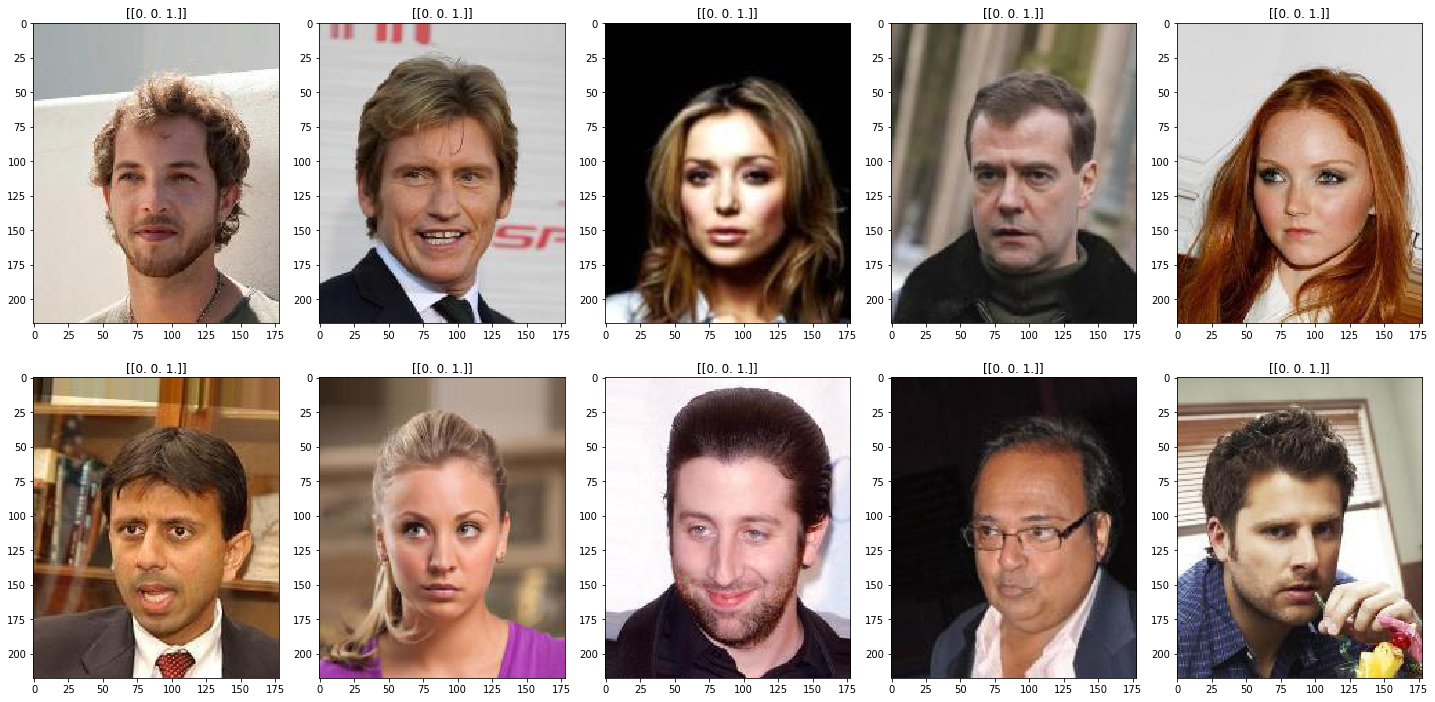

In [176]:
# show examples
plt.figure(figsize=(20,10))
columns = 5
k = 0
max_iter = 9
while k < (max_iter + 1):
    rando = np.random.randint(0, len(x_test) - 1)
    image = x_test[rando]
    plt.subplot((max_iter - 1) / columns + 1, columns, k + 1)
    plt.imshow(image)
    pred = model.predict(np.expand_dims(x_test[rando], axis=0))
    plt.title(f'{pred}')
    print(y_test[rando], pred)
    k += 1
plt.tight_layout()